In [1]:
import numpy as np
from astropy.table import Table,hstack,vstack,join
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import glob

from scipy import constants
speedoflight = constants.c / 1000.0

In [2]:
datadir = '/n/holyscratch01/conroy_lab/vchandra/mage/'

with open('/n/home03/vchandra/outerhalo/08_mage/pipeline/control/redux.txt', 'r') as file:
    redux = file.read().replace('\n','')

In [3]:
import pypeit

In [4]:
from pypeit import wavecalib

In [6]:
acat = Table.read(datadir + 'catalogs/mage_acat.fits')

In [7]:
dates = np.unique(acat['date'])

In [41]:
import matplotlib.pyplot as plt
import scipy

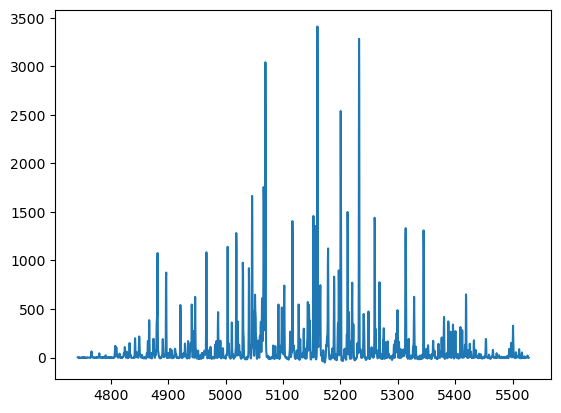

In [42]:
plt.plot(wl, arc)

In [94]:
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 1.3 MB/s eta 0:00:00a 0:00:01


In [95]:
from tqdm import tqdm

In [96]:
import lmfit

In [97]:
model = lmfit.models.GaussianModel()
params = model.make_params()
params['sigma'].set(value = 0.5)
params['amplitude'].set(value = 100)


In [134]:
wls = [];
sigmas = [];

window = 3

for date in tqdm(dates):

    wvcalibs = glob.glob(datadir + 'data/' + date + '/reduced_%s/magellan_mage_A/Masters/MasterWaveCalib*.fits' % redux)

    for wvfile in (wvcalibs):
        wc = wavecalib.WaveCalib.from_file(wvfile)

        wl, arc = wc.wv_fits[5].wave_soln, wc.wv_fits[5].spec
        peaks, _ = scipy.signal.find_peaks(arc, prominence = 150, distance = 5, width = 2)

        for peakidx in (peaks):
            peakwl = wl[peakidx]
            sel = (wl > (peakwl - window)) & (wl < (peakwl + window))
            cwl, cfl = wl[sel], arc[sel]

            params['center'].set(value = peakwl, vary = True)

            res = model.fit(cfl, params = params, x = cwl)

            # plt.plot(cwl, cfl)
            # plt.plot(cwl, model.eval(params, x = cwl), 'orange')
            # plt.plot(cwl, model.eval(res.params, x = cwl), 'r')
            # plt.show()
            
            wls.append(peakwl)
            sigmas.append(res.params['sigma'].value)

  0%|          | 0/6 [00:00<?, ?it/s][INFO]    :: Loading WaveCalib from /n/holyscratch01/conroy_lab/vchandra/mage/data/2022_08_03/reduced_v0/magellan_mage_A/Masters/MasterWaveCalib_A_2048_DET01.fits
[INFO]    :: Loading WaveCalib from /n/holyscratch01/conroy_lab/vchandra/mage/data/2022_08_03/reduced_v0/magellan_mage_A/Masters/MasterWaveCalib_A_32768_DET01.fits
[INFO]    :: Loading WaveCalib from /n/holyscratch01/conroy_lab/vchandra/mage/data/2022_08_03/reduced_v0/magellan_mage_A/Masters/MasterWaveCalib_A_8192_DET01.fits
[INFO]    :: Loading WaveCalib from /n/holyscratch01/conroy_lab/vchandra/mage/data/2022_08_03/reduced_v0/magellan_mage_A/Masters/MasterWaveCalib_A_2_DET01.fits
[INFO]    :: Loading WaveCalib from /n/holyscratch01/conroy_lab/vchandra/mage/data/2022_08_03/reduced_v0/magellan_mage_A/Masters/MasterWaveCalib_A_16_DET01.fits
[INFO]    :: Loading WaveCalib from /n/holyscratch01/conroy_lab/vchandra/mage/data/2022_08_03/reduced_v0/magellan_mage_A/Masters/MasterWaveCalib_A_12582

In [135]:
len(sigmas)

11887

In [136]:
from scipy import stats

In [137]:
wls = np.array(wls)
sigmas = np.array(sigmas)

In [138]:
cl = (sigmas > 0.2) & (sigmas < 0.65)

In [139]:
res = stats.siegelslopes(sigmas[cl], wls[cl])

In [140]:
wg = np.linspace(wls.min(), wls.max(), 1000)

In [141]:
res_sigma = wg * res.slope + res.intercept

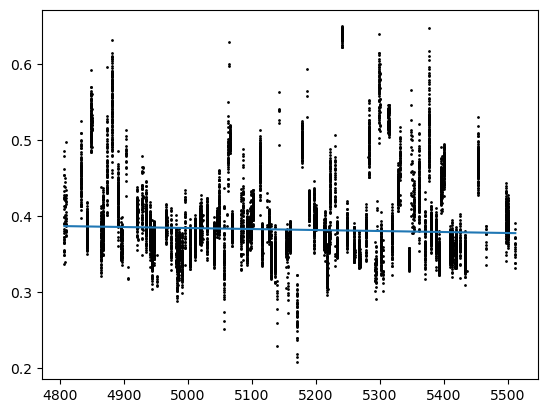

In [150]:
plt.scatter(wls[cl], sigmas[cl], s = 1, color = 'k')

plt.plot(wg, res_sigma)

#plt.ylim(0, 1)

In [143]:
res_fwhm = 2.355 * res_sigma

In [144]:
res_R = wg / res_fwhm

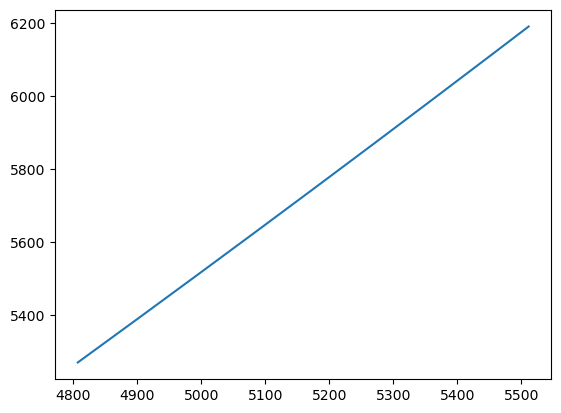

In [145]:
plt.plot(wg, res_R)

In [146]:
res_p = np.array([res.slope, res.intercept])

In [149]:
np.savetxt('/n/home03/vchandra/outerhalo/08_mage/pipeline/control/res_sigma_p.txt', res_p)

In [3]:
def getdata(GaiaID = None, acat_id = None, date = None,
                mask_hbeta = False):    
    
    acat = Table.read(datadir + 'catalogs/mage_acat.fits')
    acat = acat.filled(99.0)
    
    if acat_id is not None:
        row = acat[acat['ACAT_ID'] == acat_id]
    elif GaiaID is not None and date is not None:
        row = acat[(acat['GAIAEDR3_ID'] == GaiaID)&(acat['date'] == date)]
    # elif index is not None:
    #     row = acat[acat['ACAT_ID'] == index][0]
    else:
        print('must pass either GaiaID+date or ACAT index!!')
        raise

    if len(row) == 1:
        row = row[0]
    elif len(row) == 0:
        print('no matches in table! cannot get data...')
        raise
    elif len(row) > 1:
        print('getdata query does not return unique row in ACAT')
        raise
    
    filepath = row['specfile']

#     with fits.open(filepath) as f:
    
#         header = f[0].header

#         phot = dict(row)

#         # pull individual spectrum parts
#         wave = 10**f[1].data['LOGLAM']
#         flux = f[1].data['FLUX']
#         ivar = f[1].data['IVAR']
#         andmask = f[1].data['AND_MASK']
#         ormask  = f[1].data['OR_MASK']
#         #lsf = f[1].data['WRESL'] * lsf_fudge
#         wresl = (np.log(10) * header['CD1_1'] * f[1].data['WDISP']) * wave

#     ## QUALITY CUTS TO SPECTRUM

#     if mask_hbeta:
#         hbsel = (wave > 4830.0) & (wave < 4890)
#         ivar[hbsel] = 0.0


#     cond = (
#         np.isfinite(flux) & 
#         (ivar > 0.0) & 
#         (wresl> 0.0) &
#         (wave > 4750) &
#         (wave < 5550.0) 
#     )

#     wave   = wave[cond]
#     flux   = flux[cond]
#     ivar = ivar[cond]
#     wresl = wresl[cond]

#     medflux = np.median(flux)
#     flux /= medflux
#     ivar *= medflux**2

    #return {'phot':phot,'spec':[wave,flux,ivar,andmask,ormask,wresl]}
    return row

In [4]:
row = getdata(GaiaID = 3235246994033908352, date = '2022_11_03')

In [5]:
wvcalibs = glob.glob(datadir + 'data/' + row['date'] + '/reduced_%s/magellan_mage_A/Masters/MasterWaveCalib*.fits' % redux)

In [6]:
for wvfile in wvcalibs:
    
    f = fits.open(wvfile)
    
    break

In [7]:
import sys

In [8]:
sys.path.append('/n/home03/vchandra/software/PypeIt/')

In [11]:
from pypeit import wavecalib

ModuleNotFoundError: No module named 'github'

In [12]:
!pip install github

     |████████████████████████████████| 1.3 MB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 262 kB 50.7 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 49.2 MB/s eta 0:00:01
     |████████████████████████████████| 161 kB 71.1 MB/s eta 0:00:01


In [10]:
waveCalib = wavecalib.WaveCalib.from_file(wvfile)

AttributeError: module 'pypeit' has no attribute 'wavecalib'